<a href="https://colab.research.google.com/github/faiyaz106/Bird_Classification_using_ResNet50/blob/main/Bird_Classification_Using_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bird Classification using ResNet50

In [1]:
# Import important Library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from  tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.models import Model

In [2]:
# Loading the data from google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#Load the image
BATCH_SIZE = 16
IMG_SIZE = (256, 256)  
directory = "/content/drive/MyDrive/Bird_Data/training_set"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=0)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=0)
"""                             
## Test Set
test_directory = "/content/drive/MyDrive/Bird_Data/test_set"
test_dataset = image_dataset_from_directory(test_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
"""

Found 239 files belonging to 2 classes.
Using 192 files for training.
Found 239 files belonging to 2 classes.
Using 47 files for validation.


'                             \n## Test Set\ntest_directory = "/content/drive/MyDrive/Bird_Data/test_set"\ntest_dataset = image_dataset_from_directory(test_directory,\n                                             shuffle=True,\n                                             batch_size=BATCH_SIZE,\n                                             image_size=IMG_SIZE)\n'

In [4]:
class_names = train_dataset.class_names
class_names

['hawk', 'robin']

In [5]:
for images, labels in train_dataset.take(1):
  x=images[0].numpy().astype("uint8")
  print(x.shape)

(256, 256, 3)


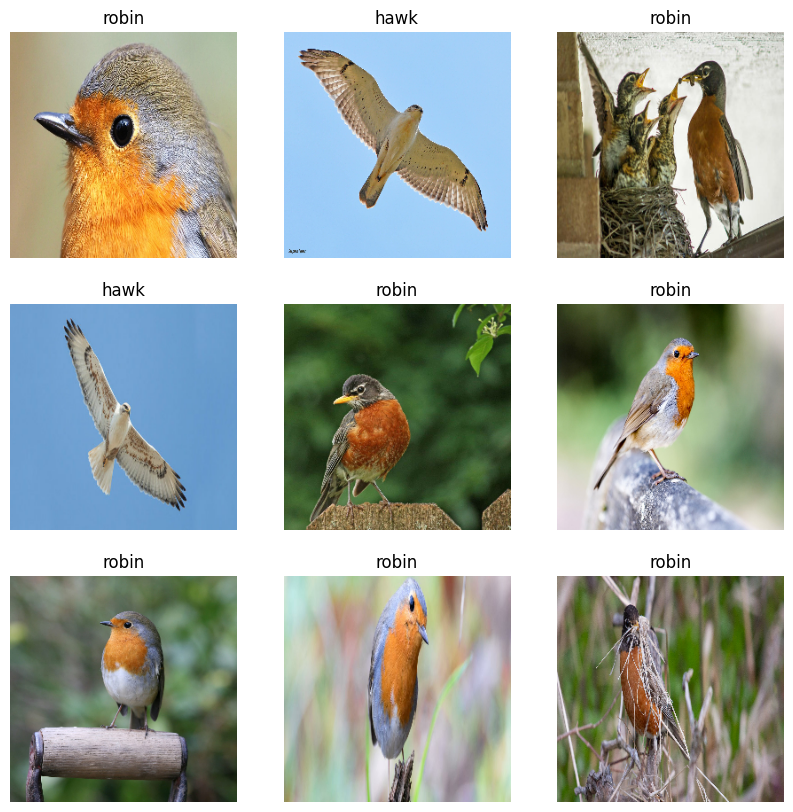

In [6]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### The details of this ResNet-50 model are:
    Zero-padding pads the input with a pad of (3,3)

    Stage 1:
    The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    BatchNorm is applied to the 'channels' axis of the input.
    MaxPooling uses a (3,3) window and a (2,2) stride.

    Stage 2:
    The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
    
    Stage 3:
    The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
    
    Stage 4:
    The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
    
    Stage 5:
    The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.

    The 2D Average Pooling uses a window of shape (2,2).
    The 'flatten' layer doesn't have any hyperparameters.
    The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [7]:
def identity_block(X,f,filters,training=True):
  """
  X: Input tensor having shape (m, n_h, n_w, c) 
  f: integer, shows filter shape i.e (f,f)
  filters: list of filters, contains the number of filters for each conv layers in main path
  training: True in training mode, else False in inference mode
  """
  F1,F2,F3=filters 
  X_skip=X  # Define the shortcut connection which will be added before 
  
  # 1st component
  X=tfl.Conv2D(filters=F1,kernel_size=1,strides=(1,1),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)

  # 2nd Component
  X=tfl.Conv2D(filters=F2,kernel_size=f,strides=(1,1),padding='same')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)  
  
  # 3rd Component
  X=tfl.Conv2D(filters=F3,kernel_size=1,strides=(1,1),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  # Concatenate the X_Skip with X
  X=tfl.Add()([X,X_skip])

  # Pass through ReLU
  X=tfl.ReLU()(X)

  return X

In [8]:
def conv_block(X,f,filters,s,training=True):
  """
  X: Input tensor having shape (m, n_h, n_w, c) 
  f: integer, i.e kernel size:(f,f)
  filters: list of filters, contains the number of filters for each conv layers in main path
  training: True in training mode, else False in inference mode
  """
  X_skip=X
  F1,F2,F3=filters

  # 1st Component
  X=tfl.Conv2D(filters=F1,kernel_size=1,strides=(s,s),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)

  # 2nd Component
  X=tfl.Conv2D(filters=F2,kernel_size=f,strides=(1,1),padding='same')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)

  # 3rd Component
  X=tfl.Conv2D(filters=F3,kernel_size=1,strides=(1,1),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)

  # Skip Connection (Conv+Batch norm)
  X_skip=tfl.Conv2D(filters=F3,kernel_size=1, strides=(s,s), padding='valid')(X_skip)
  X_skip=tfl.BatchNormalization()(X_skip,training=training)

  # Merging the X and X_skip
  X=tfl.Add()([X,X_skip])

  # ReLU layer for Merged X
  X=tfl.ReLU()(X)

  return X


In [9]:
def resnet50(input_shape = (256, 256, 3), classes = 2):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input=tfl.Input(shape=input_shape)

    # zero padding (3,3)
    X=tfl.ZeroPadding2D((3,3))(X_input)

    # Stage 1: 
    X = tfl.Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = tfl.BatchNormalization(axis =-1)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = conv_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ## Stage 3
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = conv_block(X, f = 3, filters = [128,128,512], s = 2)
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3,[128,128,512])
    X = identity_block(X, 3,[128,128,512])
    X = identity_block(X, 3,[128,128,512])

    # Stage 4 
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = conv_block(X, f = 3, filters =[256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3,[256, 256, 1024])
    X = identity_block(X, 3,[256, 256, 1024])
    X = identity_block(X, 3,[256, 256, 1024])
    X = identity_block(X, 3,[256, 256, 1024])
    X = identity_block(X, 3,[256, 256, 1024])

    # Stage 5
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = conv_block(X, f = 3, filters =[512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3,[512, 512, 2048])
    X = identity_block(X, 3,[512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = tfl.AveragePooling2D()(X)
    
    ### END CODE HERE

    # output layer
    X = tfl.Flatten()(X)
    X = tfl.Dense(1, activation='sigmoid')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [19]:
model = resnet50(input_shape = (256, 256, 3), classes = 2)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_106 (Conv2D)            (None, 128, 128, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [20]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="binary_crossentropy",metrics=['accuracy'])

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
initial_epochs = 20
history = model.fit( train_dataset,
  validation_data=validation_dataset,
  epochs=initial_epochs)

Epoch 1/20
12/12 [==============================] - 42s 322ms/step - loss: 4.4812 - accuracy: 0.5990 - val_loss: 4.3201 - val_accuracy: 0.3404
Epoch 2/20
12/12 [==============================] - 3s 229ms/step - loss: 2.1081 - accuracy: 0.6198 - val_loss: 7.3403 - val_accuracy: 0.6809
Epoch 3/20
12/12 [==============================] - 3s 220ms/step - loss: 1.5904 - accuracy: 0.7396 - val_loss: 7.7183 - val_accuracy: 0.6383
Epoch 4/20
12/12 [==============================] - 3s 220ms/step - loss: 1.6981 - accuracy: 0.6875 - val_loss: 3.7950 - val_accuracy: 0.7021
Epoch 5/20
12/12 [==============================] - 3s 220ms/step - loss: 1.5147 - accuracy: 0.7188 - val_loss: 7.5063 - val_accuracy: 0.6596
Epoch 6/20
12/12 [==============================] - 3s 222ms/step - loss: 0.8875 - accuracy: 0.8229 - val_loss: 6.1057 - val_accuracy: 0.7234
Epoch 7/20
12/12 [==============================] - 3s 220ms/step - loss: 0.4697 - accuracy: 0.8646 - val_loss: 5.9336 - val_accuracy: 0.7021
Epoch

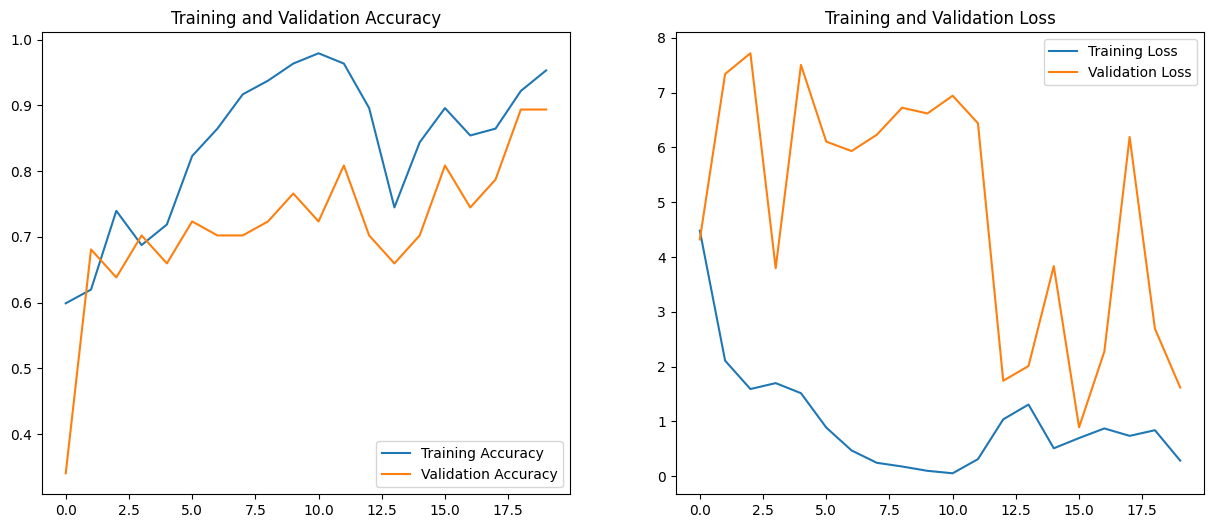

In [25]:
# Visualizing the training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Save the model
model.save('/content/drive/MyDrive/Bird_Data/model.h5')